In [276]:
import boto3
import sagemaker
from tqdm import tqdm

import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from prince.famd import FAMD
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from kneed import KneeLocator

import matplotlib.pyplot as plt
import seaborn as sns

## Helpers

In [268]:
def plot_xtab(x: pd.Series, y: pd.Series) -> None:
    """
    Plot the xtabs of two categorical variabbles.
    """
    xtab = pd.crosstab(x, y)
    xtab_norm = xtab.div(xtab.sum(axis=1), axis=0)

    xtab_norm.plot(kind="bar", stacked=True)

    plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
    plt.title(f"Cross-tabulation of {x.name} and {y.name}")
    plt.xlabel(x.name)
    plt.ylabel("Proportion")
    plt.show()

In [279]:
def plot_conditional_dist(data: pd.DataFrame, cont_col: str, cat_col: str) -> None:
    """
    Plot the conditional distribution of a continous column given a categorical column.
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    for cat_val in data[cat_col].unique():
        sns.kdeplot(
            data[data[cat_col] == cat_val][cont_col].dropna().to_numpy(),
            label=f"{cat_val}",
        )
    ax.set_title(f"{cont_col} by {cat_col}")
    ax.set_xlabel(f"{cont_col}")
    ax.set_ylabel("Density")
    ax.legend()
    plt.show()

## S3

In [7]:
s3 = boto3.client("s3")

bucket_name = "yang-ml-sagemaker"
raw_data_path = "customer_churn/raw_data"

s3_paths = sagemaker.s3.S3Downloader.list(f"s3://{bucket_name}/{raw_data_path}")
s3_paths

['s3://yang-ml-sagemaker/customer_churn/raw_data',
 's3://yang-ml-sagemaker/customer_churn/raw_data/Telco_customer_churn_demographics.csv',
 's3://yang-ml-sagemaker/customer_churn/raw_data/Telco_customer_churn_location.csv',
 's3://yang-ml-sagemaker/customer_churn/raw_data/Telco_customer_churn_population.csv',
 's3://yang-ml-sagemaker/customer_churn/raw_data/Telco_customer_churn_services.csv',
 's3://yang-ml-sagemaker/customer_churn/raw_data/Telco_customer_churn_status.csv',
 's3://yang-ml-sagemaker/customer_churn/raw_data/joined_data.csv']

## Data

In [10]:
df = pd.read_csv(
    "s3://yang-ml-sagemaker/customer_churn/raw_data/joined_data.csv", index_col=0
)
df.shape

(7043, 37)

In [12]:
df.head(5)

,Customer ID,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,Number of Referrals,Tenure in Months,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Satisfaction Score,Churn Value,CLTV,Churn Category
0,0002-ORFBO,Female,37,No,No,Yes,No,0,2,9,...,Credit Card,65.6,593.30,0.00,0,381.51,3,0,2205,NaN
1,0003-MKNFE,Male,46,No,No,No,No,0,0,9,...,Credit Card,59.9,542.40,38.33,10,96.21,5,0,5414,NaN
2,0004-TLHLJ,Male,50,No,No,No,No,0,0,4,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,1,1,4479,Competitor
3,0011-IGKFF,Male,78,No,Yes,Yes,No,0,1,13,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1,1,3714,Dissatisfaction
4,0013-EXCHZ,Female,75,No,Yes,Yes,No,0,3,3,...,Credit Card,83.9,267.40,0.00,0,22.14,1,1,3464,Dissatisfaction


In [51]:
X, y = df.drop(["Churn Value", "Customer ID"], axis=1), df["Churn Value"]

In [52]:
X.dtypes

Gender                                object
Age                                    int64
Under 30                              object
Senior Citizen                        object
Married                               object
Dependents                            object
Number of Dependents                   int64
Number of Referrals                    int64
Tenure in Months                       int64
Offer                                 object
Phone Service                         object
Avg Monthly Long Distance Charges    float64
Multiple Lines                        object
Internet Service                      object
Internet Type                         object
Avg Monthly GB Download                int64
Online Security                       object
Online Backup                         object
Device Protection Plan                object
Premium Tech Support                  object
Streaming TV                          object
Streaming Movies                      object
Streaming 

In [66]:
# Columns
cat_cols = [
    "Gender",
    "Under 30",
    "Senior Citizen",
    "Married",
    "Dependents",
    "Offer",
    "Phone Service",
    "Avg Monthly Long Distance Charges",
    "Multiple Lines",
    "Internet Service",
    "Internet Type",
    "Avg Monthly GB Download",
    "Online Security",
    "Online Backup",
    "Device Protection Plan",
    "Premium Tech Support",
    "Streaming TV",
    "Streaming Movies",
    "Streaming Music",
    "Unlimited Data",
    "Contract",
    "Paperless Billing",
    "Payment Method",
    "Churn Category",
]
num_cols = list(set(X.columns) - set(cat_cols))

# Check that no missing columns
assert set(cat_cols + num_cols) == set(X.columns)

# Convert dtypes from object to cateogrical
X[cat_cols] = X[cat_cols].astype("category")

In [67]:
X.dtypes

Gender                               category
Age                                     int64
Under 30                             category
Senior Citizen                       category
Married                              category
Dependents                           category
Number of Dependents                    int64
Number of Referrals                     int64
Tenure in Months                        int64
Offer                                category
Phone Service                        category
Avg Monthly Long Distance Charges    category
Multiple Lines                       category
Internet Service                     category
Internet Type                        category
Avg Monthly GB Download              category
Online Security                      category
Online Backup                        category
Device Protection Plan               category
Premium Tech Support                 category
Streaming TV                         category
Streaming Movies                  

## Target Class Distribution

In [68]:
y.value_counts() / y.shape[0]

0    0.73463
1    0.26537
Name: Churn Value, dtype: float64

Note: There is imbalanced in the class distribution. Need to investigate whether there are compounding factors such as linear seperability issues and noise, making it even harder to learn the function.

## Missingness

In [69]:
df.isna().sum()

Customer ID                             0
Gender                                  0
Age                                     0
Under 30                                0
Senior Citizen                          0
Married                                 0
Dependents                              0
Number of Dependents                    0
Number of Referrals                     0
Tenure in Months                        0
Offer                                   0
Phone Service                           0
Avg Monthly Long Distance Charges       0
Multiple Lines                          0
Internet Service                        0
Internet Type                           0
Avg Monthly GB Download                 0
Online Security                         0
Online Backup                           0
Device Protection Plan                  0
Premium Tech Support                    0
Streaming TV                            0
Streaming Movies                        0
Streaming Music                   

In [16]:
df["Churn Category"].unique()

array([nan, 'Competitor', 'Dissatisfaction', 'Other', 'Price', 'Attitude'],
      dtype=object)

Investigate relationship between churn category and target using chi-squared test of independence between two categorical variables:

In [41]:
pd.crosstab(index=y.map({1: "yes", 0: "no"}), columns=X["Churn Category"])

Churn Category,Attitude,Competitor,Dissatisfaction,Other,Price
Churn Value,,,,,
yes,314,841,303,200,211


Churn category is missing if the customer did not leave.

In [44]:
chi2_contingency(
    pd.crosstab(index=y.map({1: "yes", 0: "no"}), columns=X["Churn Category"])
)

Chi2ContingencyResult(statistic=0.0, pvalue=1.0, dof=0, expected_freq=array([[314., 841., 303., 200., 211.]]))

Fail to reject the null hypothesis of independence at any significance level. 

This feature may not be useful for prediction tasks since it can not be observed for those who did not churn. It also does not make sense to impute this value for those who did not churn.

## FAMD

In [85]:
famd = FAMD(n_components=50, n_iter=5)

famd.fit(X)

FAMD(n_components=50, n_iter=5)

In [86]:
# Check scree plot
famd.scree_plot()

alt.Chart(...)

The data appears to be intrinsically low-dimensional:

In [87]:
print(
    f"We need {np.where(famd.cumulative_percentage_of_variance_ > 0.9)[0].min()} components to explain > 90% of variance in the data"
)

We need 13 components to explain > 90% of variance in the data


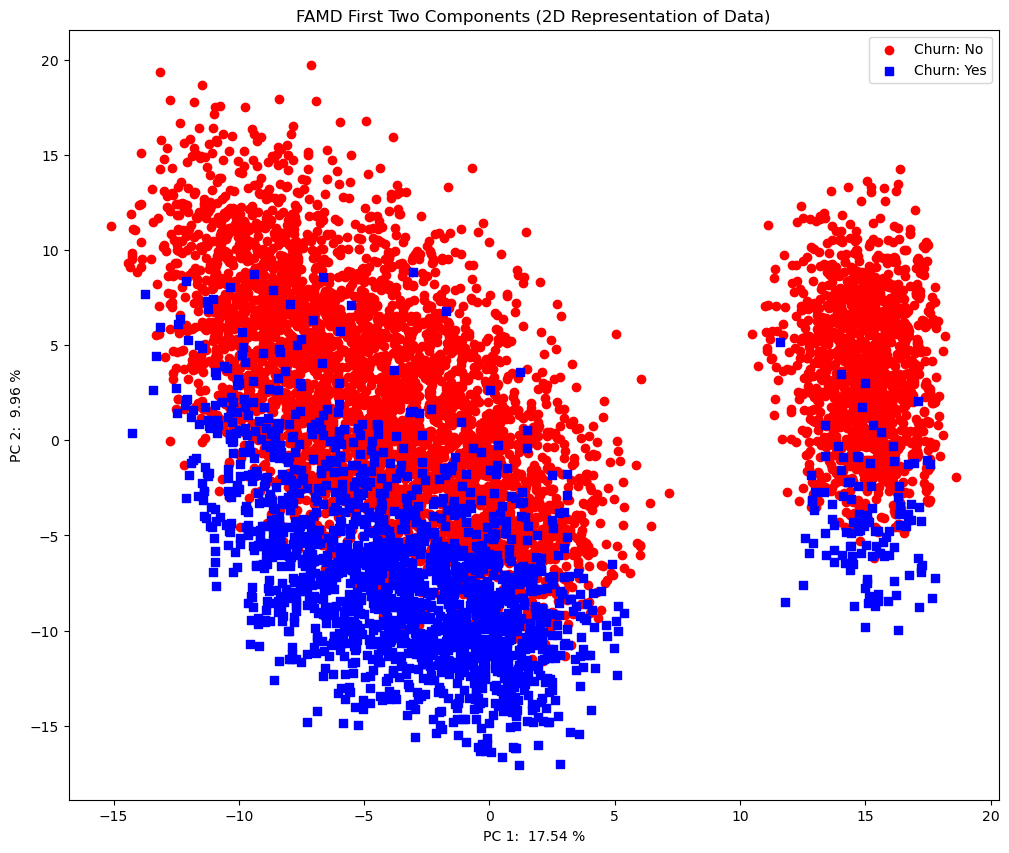

In [144]:
# First two components
pcs = famd.row_coordinates(X).iloc[:, :2]
# Add target
pcs["target"] = y

# Plot
fig, ax = plt.subplots(figsize=(12, 10))
colors = ["red", "blue"]
markers = ["o", "s"]
for c in np.unique(pcs["target"]):
    mask = pcs["target"] == c
    ax.scatter(pcs[0][mask], pcs[1][mask], c=colors[c], marker=markers[c])
plt.title("FAMD First Two Components (2D Representation of Data)")
plt.xlabel(f"PC 1: {famd.percentage_of_variance_[0] * 100: .2f} %")
plt.ylabel(f"PC 2: {famd.percentage_of_variance_[1] * 100: .2f} %")
plt.legend(["Churn: No", "Churn: Yes"], loc="upper right")
plt.show();

## Customer ID

Check how many unique customers are there. If there are many repeated observations for each customers, we can construct new features for each by using aggregation functions:

In [148]:
df.shape[0] - df["Customer ID"].unique().shape[0]

0

## Clustering with K-Prototypes

In [175]:
# Drop churn category columns
X.drop(["Churn Category"], axis=1, inplace=True)

# Pipeline for kprototype
krototypes_pipeline = Pipeline(
    [
        (
            "num_pipeline",
            ColumnTransformer(
                [("normalizer", Normalizer(), num_cols)], remainder="passthrough"
            ),
        )
    ]
)

krototypes_pipeline.set_output(transform="pandas")

# Data for clustering
cluster_data = krototypes_pipeline.fit_transform(X, y)
cluster_data.head(5)

,normalizer__Total Long Distance Charges,normalizer__Number of Referrals,normalizer__Total Refunds,normalizer__Total Charges,normalizer__CLTV,normalizer__Age,normalizer__Satisfaction Score,normalizer__Tenure in Months,normalizer__Monthly Charge,normalizer__Number of Dependents,...,remainder__Online Backup,remainder__Device Protection Plan,remainder__Premium Tech Support,remainder__Streaming TV,remainder__Streaming Movies,remainder__Streaming Music,remainder__Unlimited Data,remainder__Contract,remainder__Paperless Billing,remainder__Payment Method
0,0.164705,0.000863,0.000000,0.256139,0.951940,0.015974,0.001295,0.003885,0.028321,0.0,...,Yes,No,Yes,Yes,No,No,Yes,One Year,Yes,Credit Card
1,0.017677,0.000000,0.007043,0.099658,0.994740,0.008452,0.000919,0.001654,0.011006,0.0,...,No,No,No,No,Yes,Yes,No,Month-to-Month,No,Credit Card
2,0.029973,0.000000,0.000000,0.062540,0.997394,0.011134,0.000223,0.000891,0.016456,0.0,...,No,Yes,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal
3,0.091943,0.000254,0.000000,0.314691,0.944188,0.019829,0.000254,0.003305,0.024914,0.0,...,Yes,Yes,No,Yes,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal
4,0.006369,0.000863,0.000000,0.076923,0.996490,0.021575,0.000288,0.000863,0.024136,0.0,...,No,No,Yes,Yes,No,No,Yes,Month-to-Month,Yes,Credit Card


In [198]:
# Find optimal number of clusters
cost = {}
# Indices of categorical columns
cluster_cat_cols = cat_indices = [
    index
    for index, element in enumerate(cluster_data.columns)
    if element in cluster_data.select_dtypes(include="category").columns.tolist()
]
for n_clusters in tqdm(range(2, 10)):
    kproto_model = KPrototypes(n_clusters=n_clusters, n_jobs=-1)
    kproto_model.fit(cluster_data, categorical=cluster_cat_cols)
    cost[n_clusters] = kproto_model.cost_

100%|██████████| 8/8 [38:03<00:00, 285.38s/it]


Plot cost as as function of cluster numbers:

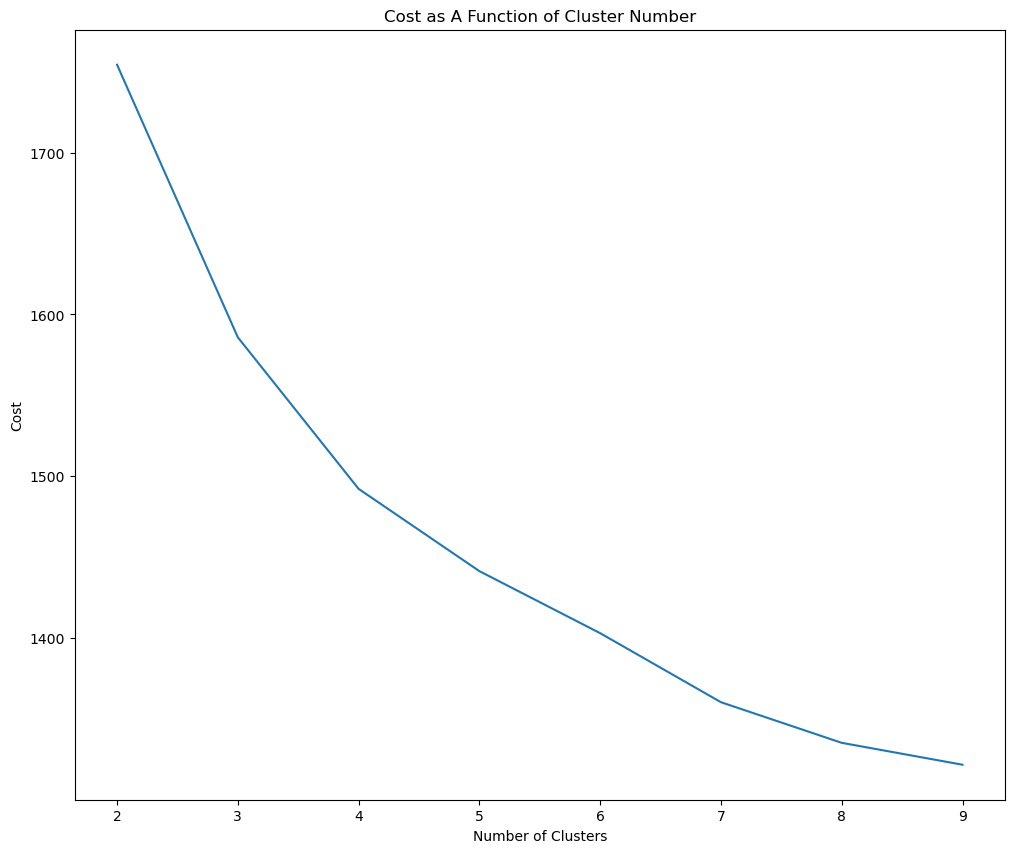

In [210]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.plot(cost.keys(), cost.values())
plt.xlabel("Number of Clusters")
plt.ylabel("Cost")
plt.title("Cost as A Function of Cluster Number")
plt.show();

Using the kneedle algorithm:

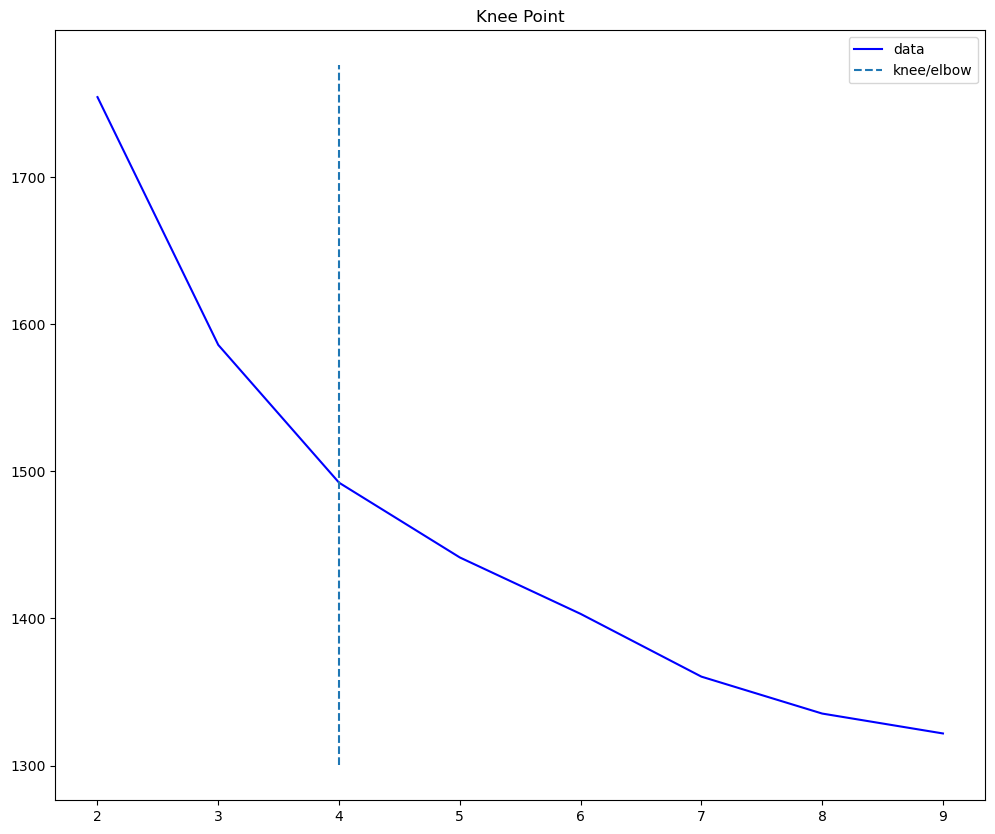

In [232]:
kneedle = KneeLocator(
    x=list(cost.keys()),
    y=list(cost.values()),
    curve="convex",
    direction="decreasing",
    interp_method="polynomial",
)
kneedle.plot_knee(figsize=(12, 10))

Fit cluster model with heuristic optimal `k`:

In [236]:
kproto_model = KPrototypes(n_clusters=kneedle.knee, n_jobs=-1)

kproto_model.fit(cluster_data, categorical=cluster_cat_cols)

KPrototypes(gamma=0.026313170361580564, n_clusters=4, n_jobs=-1)

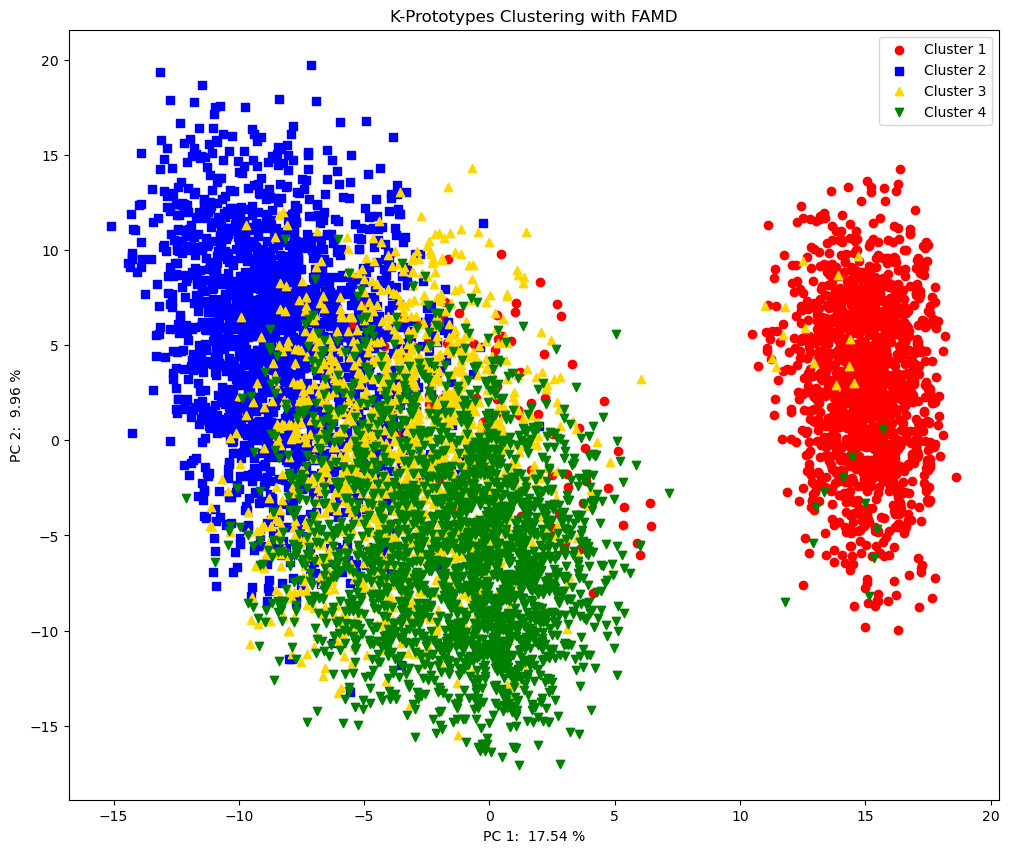

In [238]:
# Add cluster labels
pcs["cluster_labels"] = kproto_model.labels_

# Plot
fig, ax = plt.subplots(figsize=(12, 10))
colors = ["red", "blue", "gold", "green"]
markers = ["o", "s", "^", "v"]
for c in np.unique(pcs["cluster_labels"]):
    mask = pcs["cluster_labels"] == c
    ax.scatter(pcs[0][mask], pcs[1][mask], c=colors[c], marker=markers[c])

plt.title("K-Prototypes Clustering with FAMD")
plt.xlabel(f"PC 1: {famd.percentage_of_variance_[0] * 100: .2f} %")
plt.ylabel(f"PC 2: {famd.percentage_of_variance_[1] * 100: .2f} %")
plt.legend(["Cluster " + str(i + 1) for i in range(4)], loc="upper right")
plt.show();

## Cluster Analysis

In [241]:
# Add cluster label to feature matrix
X["cluster_label"] = kproto_model.labels_

### Gender

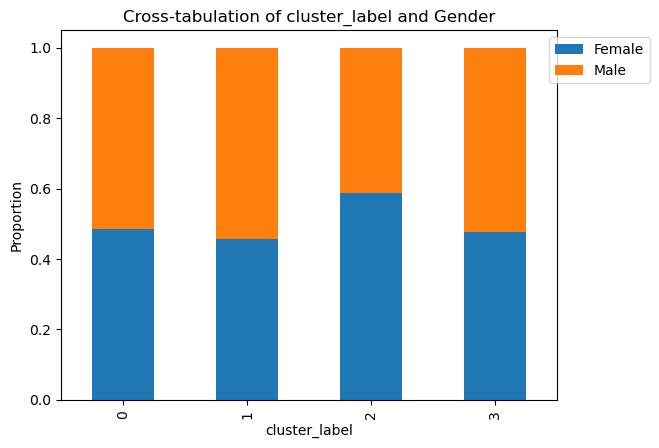

In [270]:
plot_xtab(X["cluster_label"], X["Gender"])

### Offer

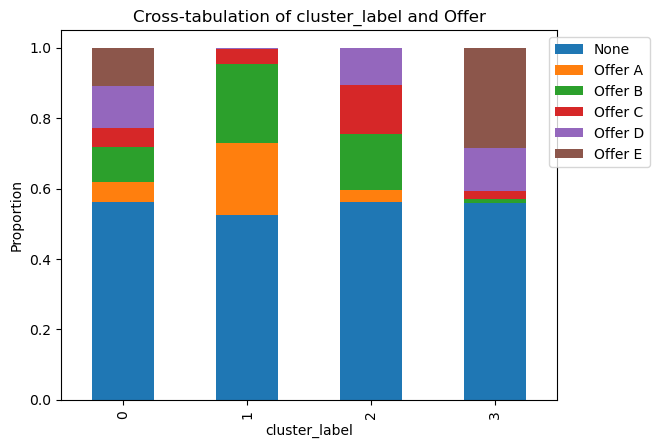

In [275]:
plot_xtab(X["cluster_label"], X["Offer"])

### Payment Method

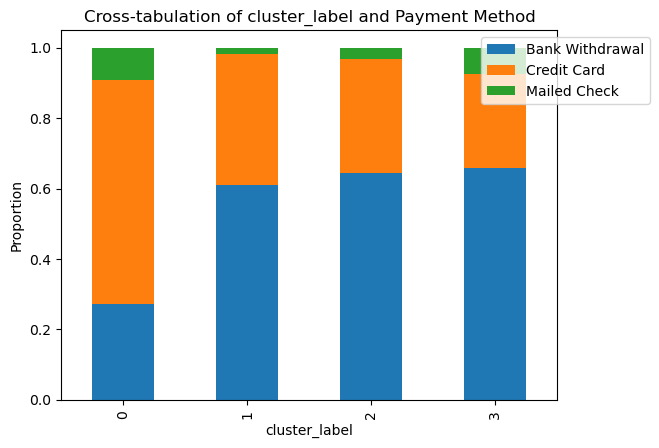

In [274]:
plot_xtab(X["cluster_label"], X["Payment Method"])

Most cluster 0 customers use credit card as the payment method.

### Internet

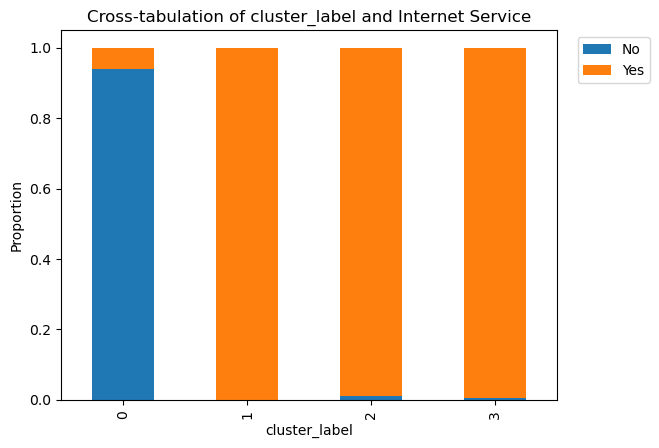

In [292]:
plot_xtab(X["cluster_label"], X["Internet Service"])

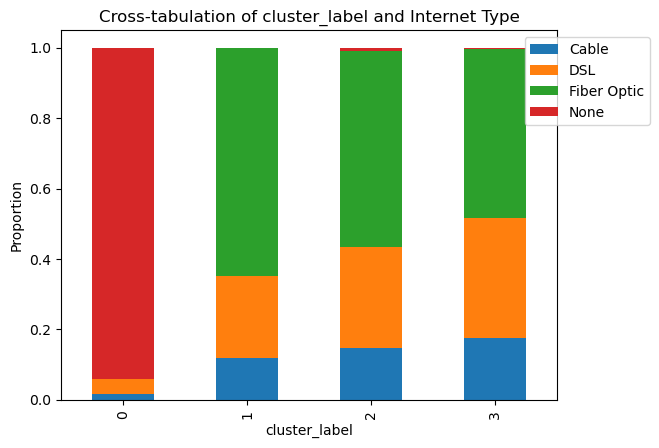

In [293]:
plot_xtab(X["cluster_label"], X["Internet Type"])

Many cluster 0 customers do not have inter service. This could be explained by the fact that this cluster has higher density for older customers.

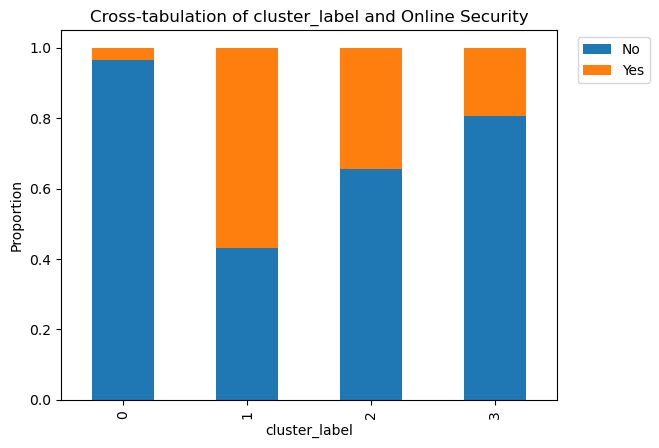

In [296]:
plot_xtab(X["cluster_label"], X["Online Security"])

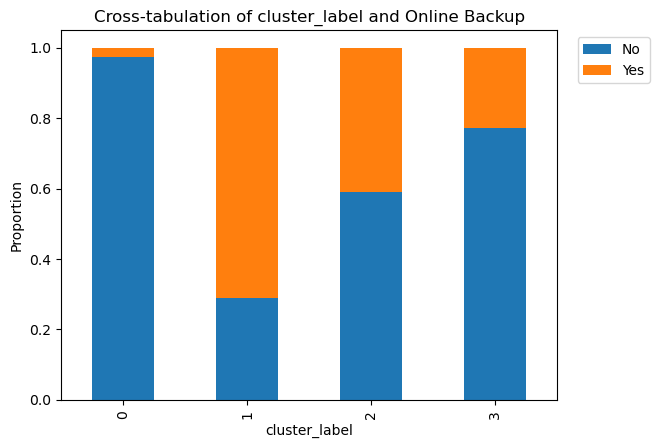

In [297]:
plot_xtab(X["cluster_label"], X["Online Backup"])

Generally, cluster 0 customers appear to be less internet-savy.

### Device Protection Plan

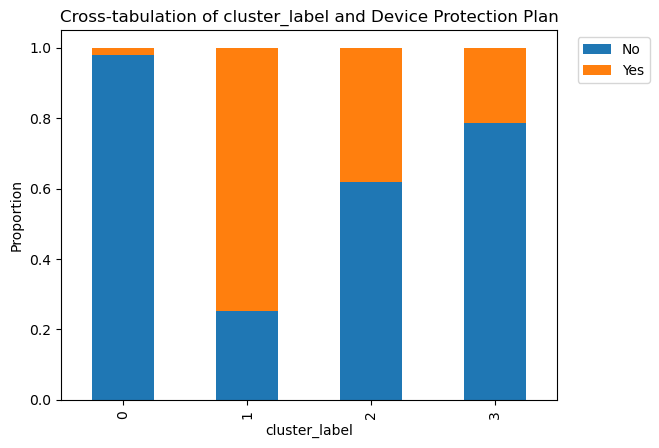

In [298]:
plot_xtab(X["cluster_label"], X["Device Protection Plan"])

### Premium Tech Support

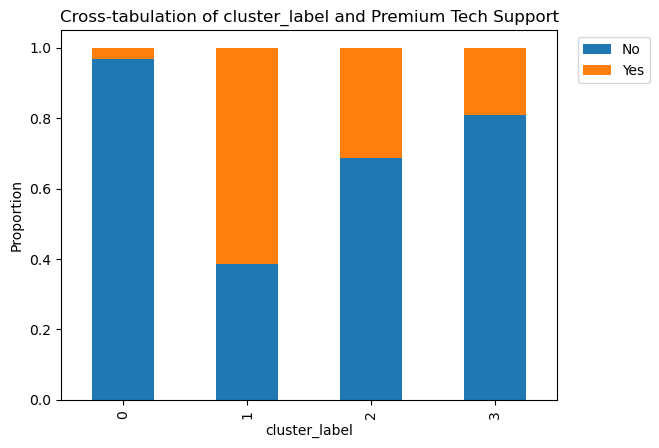

In [299]:
plot_xtab(X["cluster_label"], X["Premium Tech Support"])

Most customers in cluster 0 also do not have tech-support and device protection.

### Contract Type

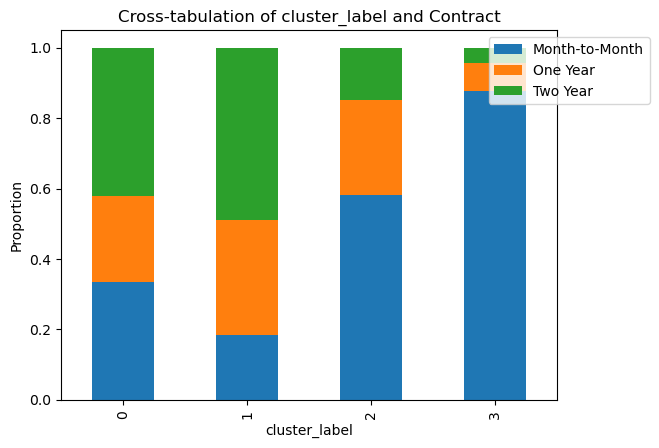

In [304]:
plot_xtab(X["cluster_label"], X["Contract"])

Cluster 3 customers have shorter term contracts. This may be explained by the fact that many cluster 3 customers are newer (shorter tenure in months), as shown below in the conditional distribution plot.

### Paperless Billing

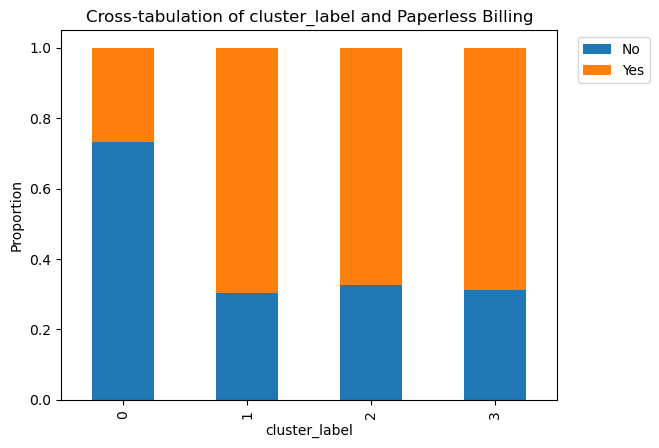

In [305]:
plot_xtab(X["cluster_label"], X["Paperless Billing"])

### Age

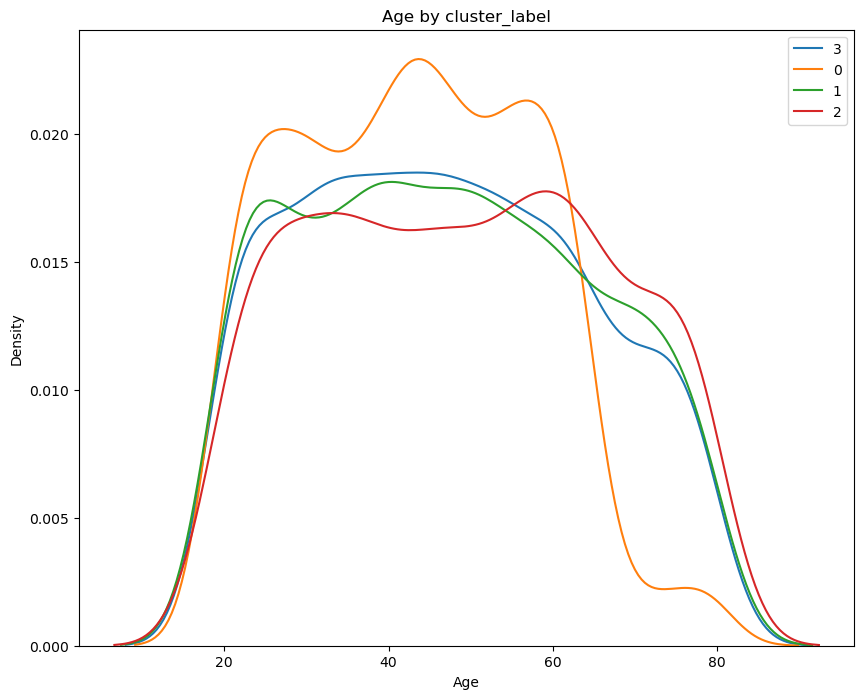

In [280]:
plot_conditional_dist(X, "Age", "cluster_label")

### Satisfaction Score

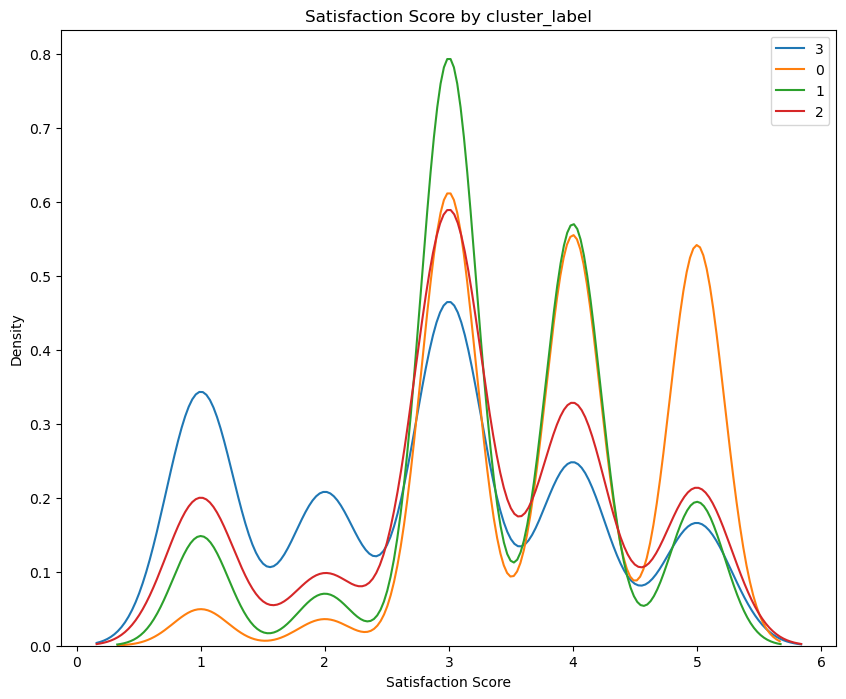

In [281]:
plot_conditional_dist(X, "Satisfaction Score", "cluster_label")

Cluster 0 has a lot of density at `score=5`.

### Tenure in Months

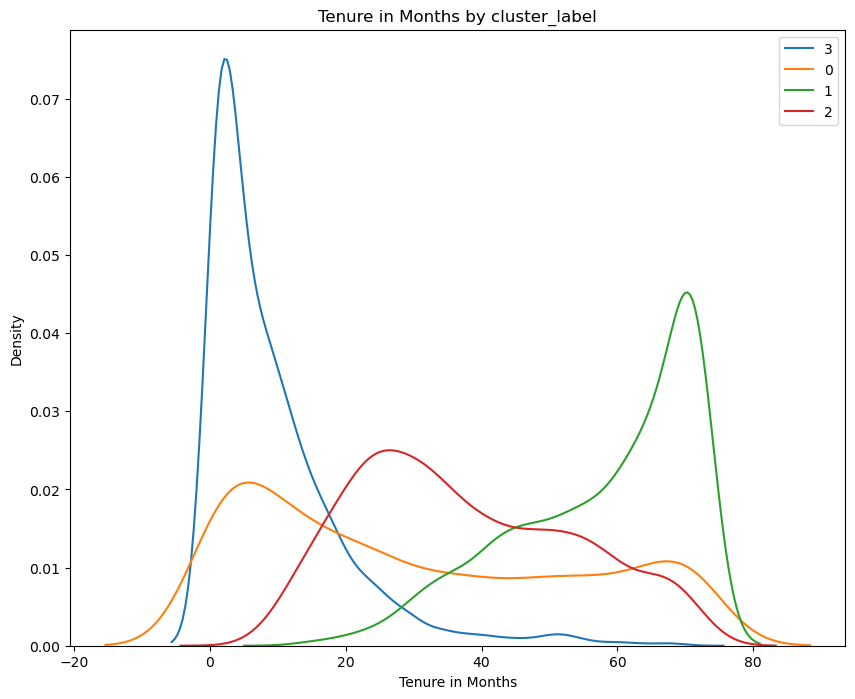

In [282]:
plot_conditional_dist(X, "Tenure in Months", "cluster_label")

Cluster 3 represents newer customers while cluster 1 contains more longer-term customers.

### CLTV

Text(0, 0.5, 'Value in Millions')

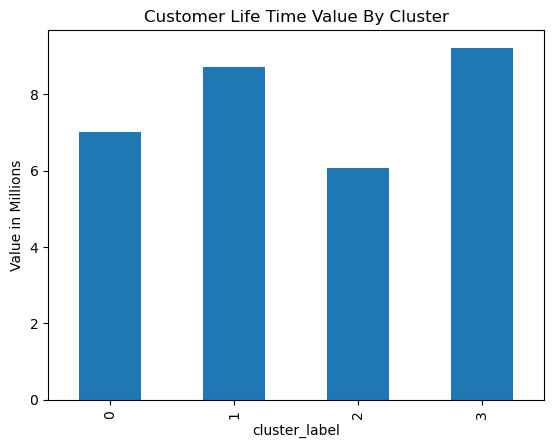

In [289]:
(X.groupby("cluster_label")["CLTV"].sum() / 1000000).plot(kind="bar")
plt.title("Customer Life Time Value By Cluster")
plt.ylabel("Value in Millions")

Cluster 3 (with more newer customers) have higher total customer life time value.

### Refund

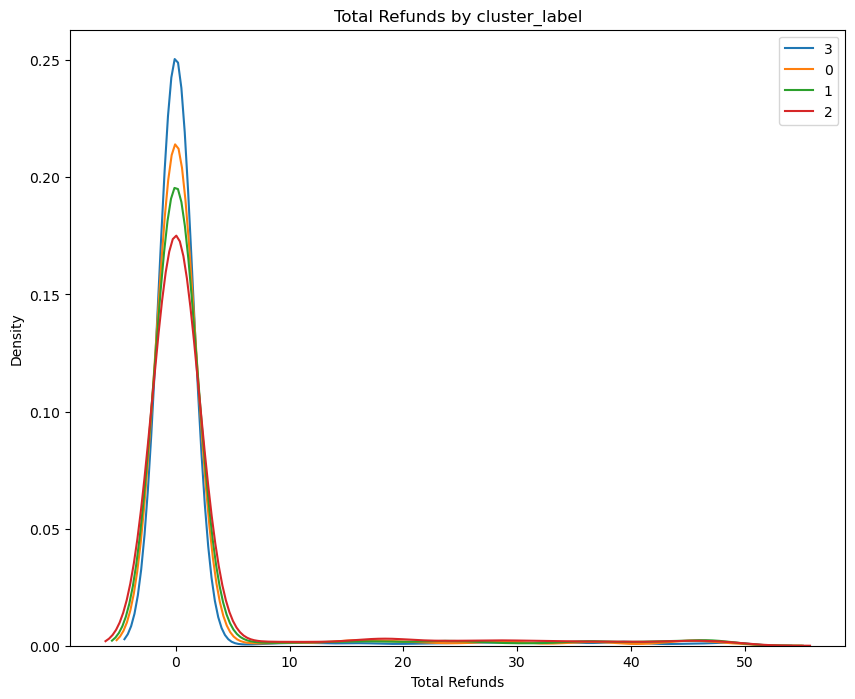

In [302]:
plot_conditional_dist(X, "Total Refunds", "cluster_label")

### Monthly Charges

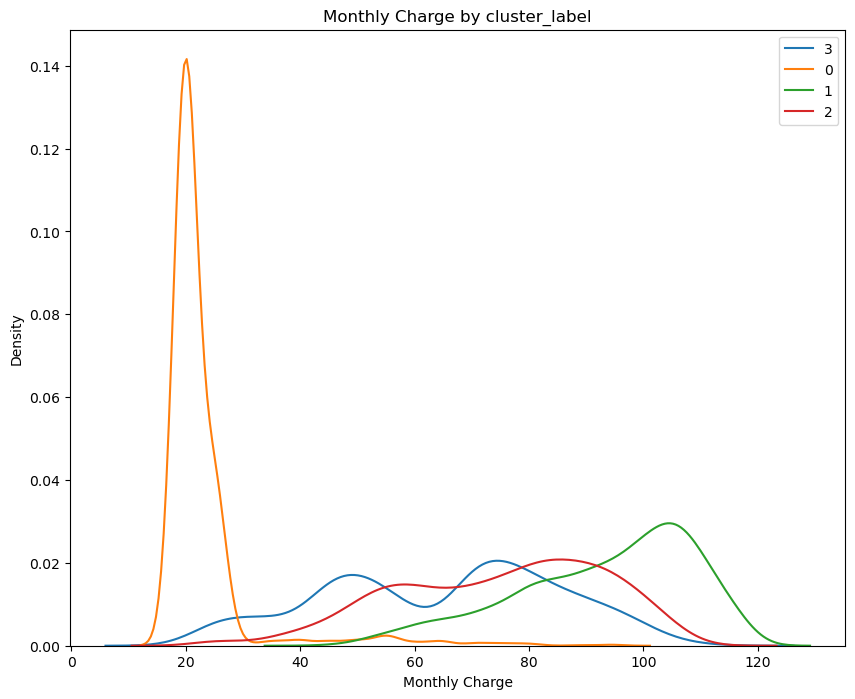

In [306]:
plot_conditional_dist(X, "Monthly Charge", "cluster_label")

Cluster 0 customers have greater densities in lower monthly changes.

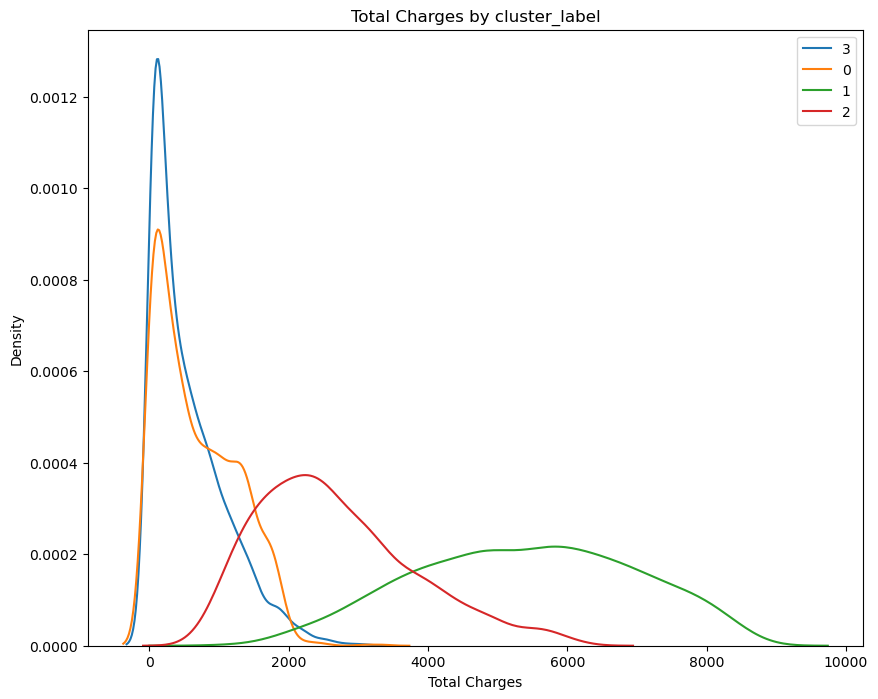

In [308]:
plot_conditional_dist(X, "Total Charges", "cluster_label")

Both cluster 0 and 3 have relatively higher densities in lower values ranges of total charges.